Rizqy Eka Putra 
1103184149
School Of Electrical Engineering - Computer Engineering
Telkom University

In [2]:
#Load library needed for the classification
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Load Both train and test dataset
#Also convert images data to tensor using transform.ToTensor()
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, 
transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])) 


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
#Split data test 90% for validation and 10% for test
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 *    len(mnist_testset)), int(0.1 * len(mnist_testset))])

In [5]:
#Add iterable over dataset with DataLoader
# Set batch size to 64 for train and 32 for test and validation 
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

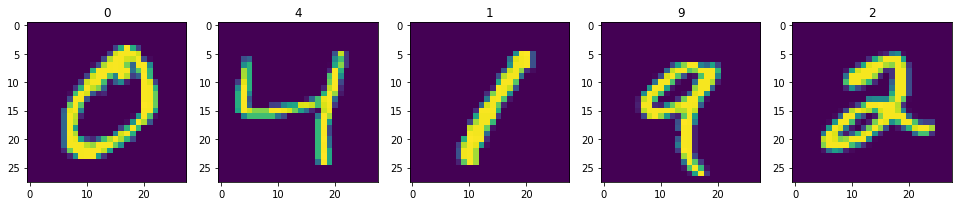

In [6]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [7]:
#this section is model definition using CNN with 2 Convolution layers
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #first and second convolution layer
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
       
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)  # a max-pooling layer with kernel size of 2 and stride 2
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128) #flattened version of the feature maps will be passed to the first fully connected layer
        self.linear_2 = torch.nn.Linear(128, 10) #final layer so the output dimension should match the total classes which is 10.
        self.dropout = torch.nn.Dropout(p=0.5) # dropout connections between the two linear layers to reduce overfitting 
        self.relu = torch.nn.ReLU() #RelU activation function 
        # The down-sampled feature map will have dimension 64 x 7 x 7

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [9]:
model = Model() #instantiate model class to a variable

In [11]:
criterion = torch.nn.CrossEntropyLoss() #used because multi class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
#if machine where the code is run has cuda supported torch
if (torch.cuda.is_available()):
    model.cuda()


Epoch: 1/100, Train Loss: 0.25603717, Val Loss: 0.04812934, Val Accuracy: 0.98422222
Saving the model state dictionary for Epoch: 1 with Validation loss: 0.04812934

Epoch: 2/100, Train Loss: 0.08537681, Val Loss: 0.03778410, Val Accuracy: 0.98811111
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.03778410

Epoch: 3/100, Train Loss: 0.06420031, Val Loss: 0.03159324, Val Accuracy: 0.99044444
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.03159324

Epoch: 4/100, Train Loss: 0.05282447, Val Loss: 0.02643566, Val Accuracy: 0.99133333
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.02643566

Epoch: 5/100, Train Loss: 0.04598555, Val Loss: 0.02777986, Val Accuracy: 0.99100000

Epoch: 6/100, Train Loss: 0.03960371, Val Loss: 0.02189499, Val Accuracy: 0.99277778
Saving the model state dictionary for Epoch: 6 with Validation loss: 0.02189499

Epoch: 7/100, Train Loss: 0.03487502, Val Loss: 0.02480462, Val Accuracy: 0.9917777

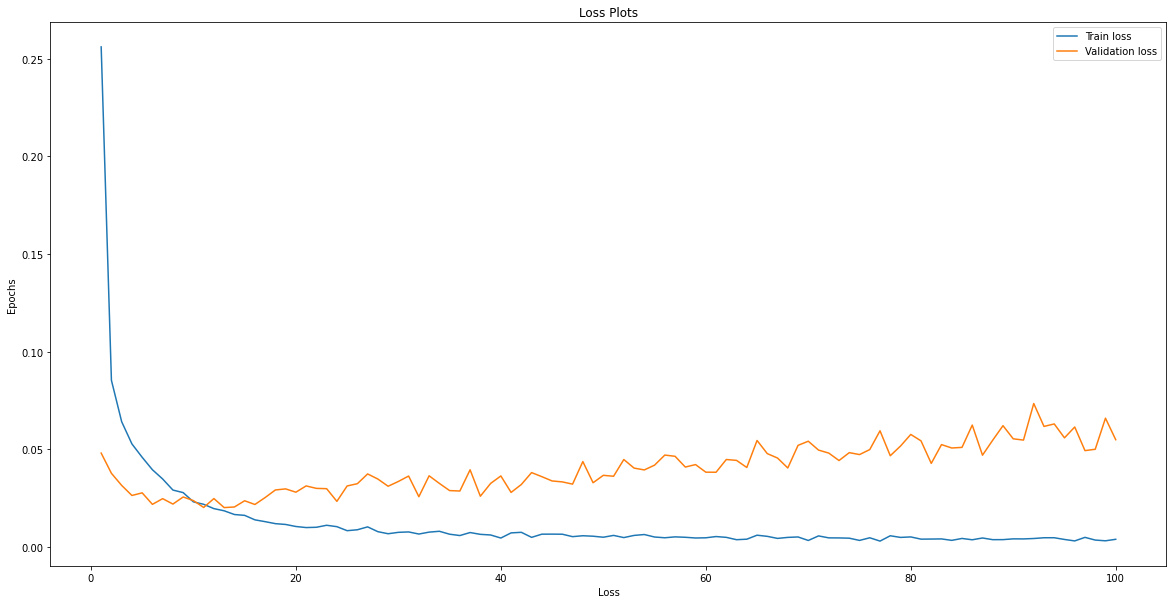

In [13]:
no_epochs = 100
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):
        optimizer.zero_grad()

        pred = model(image)
        
        #predictions value passed into the cross entropy loss criterion along with the 
        #actual labels and calculate the loss
        loss = criterion(pred, label)
        total_train_loss += loss.item()
        
        #backward pass using loss value and use Adam optimizer to modify the model parameters
        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)
    
    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):
        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
# plt.show()
plt.savefig('loss.png')

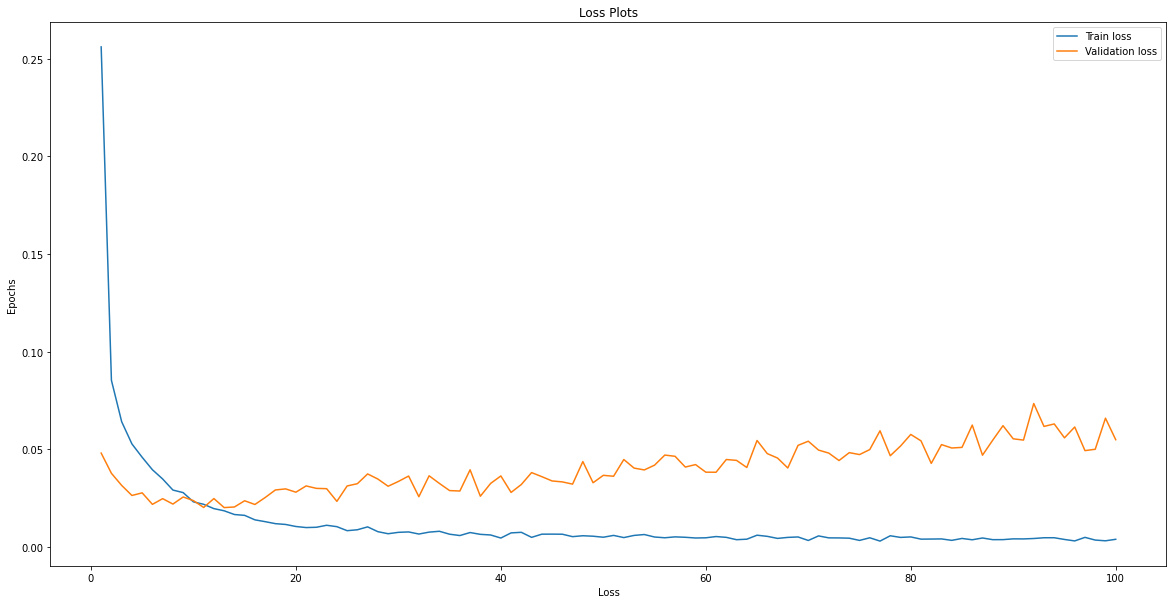

In [14]:
#Visualizing the training and validation loss
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [15]:
# test model
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
for itr, (image, label) in enumerate(test_dataloader):
    pred = model(image)
    pred = torch.nn.functional.softmax(pred, dim=1)

    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / (itr + 1)
print('Test accuracy {:.8f}'.format(test_accuracy))

# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 11):
    img = transforms.ToPILImage(mode='L')(results[i][0].squeeze(0))
    fig.add_subplot(2, 5, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
plt.show()

Test accuracy 30.90625000


ValueError: ignored

<Figure size 1440x720 with 0 Axes>